In [1]:
import os
import cv2
import seaborn as sns
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class_names=['buildings','glacier','sea','mountain','forest','street']
class_names_labels={class_name:i for i,class_name in enumerate(class_names)}
print(class_names_labels)
image_size=(150,150)

paths=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:   
        paths.append(os.path.join(dirname, filename))        

{'buildings': 0, 'glacier': 1, 'sea': 2, 'mountain': 3, 'forest': 4, 'street': 5}


In [2]:
train_images,train_labels=[],[]
test_images,test_labels=[],[]

for i in paths:
    for x in class_names:
        if x in i:
            label=x
    if 'seg_train' in i:
        image=cv2.imread(i)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,image_size)
            
        train_images.append(image)
        train_labels.append(label)
    if 'seg_test' in i:
        image=cv2.imread(i)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,image_size)
            
        test_images.append(image)
        test_labels.append(label)
        
train_images=np.array(train_images,dtype='float32')
train_labels=np.array(list(map(class_names_labels.get,train_labels)),dtype='int32')
test_images=np.array(test_images,dtype='float32')
test_labels=np.array(list(map(class_names_labels.get,test_labels)),dtype='int32')

In [3]:
### Shuffling all the labels
train_images,train_labels=shuffle(train_images,train_labels,random_state=10)

#Normalizing the values between 0 to 1 so that it helps in faster processing
train_images=train_images/255.0
test_images=test_images/255.0

['street']


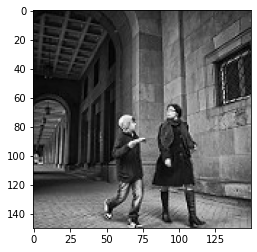

In [4]:
image=np.random.randint(train_images.shape[0])
plt.imshow(train_images[image])
x=[key for key,value in class_names_labels.items() if value==train_labels[image]]
print(x)

In [5]:
from keras.callbacks import EarlyStopping

model2=tf.keras.Sequential([
    tf.keras.layers.Conv2D(300,(4,4),activation='relu',kernel_initializer='uniform',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(300,(4,4),activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(300,(4,4),activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(300,(4,4),activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256,activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256,activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu',kernel_initializer='uniform'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(6,activation='softmax')
])

model2.compile(optimizer='adamax',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

earlystop=EarlyStopping(monitor='val_loss',mode='min',patience=5)
history=model2.fit(train_images,train_labels,batch_size=10,epochs=10,validation_data=(test_images,test_labels),callbacks=[earlystop])

Epoch 1/10
1404/1404 [==============================] - 124s 88ms/step - loss: 1.3184 - accuracy: 0.4365 - val_loss: 0.9265 - val_accuracy: 0.6250
Epoch 2/10
1404/1404 [==============================] - 123s 87ms/step - loss: 0.9199 - accuracy: 0.6455 - val_loss: 0.9181 - val_accuracy: 0.6630
Epoch 3/10
1404/1404 [==============================] - 123s 87ms/step - loss: 0.7667 - accuracy: 0.7223 - val_loss: 0.5890 - val_accuracy: 0.7923
Epoch 4/10
1404/1404 [==============================] - 122s 87ms/step - loss: 0.6262 - accuracy: 0.7865 - val_loss: 0.5345 - val_accuracy: 0.8043
Epoch 5/10
1404/1404 [==============================] - 122s 87ms/step - loss: 0.5247 - accuracy: 0.8236 - val_loss: 0.5549 - val_accuracy: 0.8130
Epoch 6/10
1404/1404 [==============================] - 122s 87ms/step - loss: 0.4505 - accuracy: 0.8552 - val_loss: 0.4808 - val_accuracy: 0.8343
Epoch 7/10
1404/1404 [==============================] - 122s 87ms/step - loss: 0.3875 - accuracy: 0.8732 - val_loss: 0

In [7]:
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def Evaluation(images,labels):  
    pred_labels=np.argmax(model2.predict(images),axis=1)
    print(classification_report(labels,pred_labels))
    #cm=confusion_matrix(labels,pred_test_labels)
    #sns.heatmap(cm,xticklabels=class_names_labels,yticklabels=class_names_labels,annot=True)
    
#Evaluation(train_images,train_labels)
Evaluation(test_images,test_labels)


              precision    recall  f1-score   support

           0       0.85      0.81      0.83       437
           1       0.88      0.74      0.81       553
           2       0.82      0.93      0.87       510
           3       0.81      0.83      0.82       525
           4       0.96      0.96      0.96       474
           5       0.83      0.89      0.86       501

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000

